In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset

In [4]:
OUTPUT_DIR = "./dataset"
FILE_PATH = os.path.join(OUTPUT_DIR, "fineweb-6b.parquet")

In [5]:
dataset = load_dataset("parquet", data_files={
    "train": FILE_PATH
}, split="train")
dataset

Generating train split: 8548517 examples [00:20, 417303.96 examples/s]


Dataset({
    features: ['text', 'meta', 'id'],
    num_rows: 8548517
})

In [6]:
dataset.features

{'text': Value('string'),
 'meta': {'url': Value('string'),
  'dump': Value('string'),
  's_cluster': Value('int64'),
  'token_count': Value('int64')},
 'id': Value('string')}

In [11]:
from pprint import pprint
pprint(dataset[0])

{'id': '<urn:uuid:d66bc6fe-8477-4adf-b430-f6a558ccc8ff>',
 'meta': {'dump': None, 's_cluster': None, 'token_count': None, 'url': None},
 'text': 'How AP reported in all formats from tornado-stricken regionsMarch 8, '
         '2012\n'
         'When the first serious bout of tornadoes of 2012 blew through middle '
         'America in the middle of the night, they touched down in places '
         'hours from any AP bureau. Our closest video journalist was '
         'Chicago-based Robert Ray, who dropped his plans to travel to Georgia '
         'for Super Tuesday, booked several flights to the cities closest to '
         'the strikes and headed for the airport. He’d decide once there which '
         'flight to take.\n'
         'He never got on board a plane. Instead, he ended up driving toward '
         'Harrisburg, Ill., where initial reports suggested a town was '
         'destroyed. That decision turned out to be a lucky break for the AP. '
         'Twice.\n'
         'Ray w

In [23]:
len(tokenizer(dataset[0]['text'])['input_ids'])

728

# **Document Length Analysis**
> Understanding length of the document is crucial for setting effective padding/truncation strategies during training.

**A. Apply tokenizer and map**
- We'll use `map` function to calculate the token count for every document
- We'll store it in a new column
  - hf's `map` is highly optimized and works well with large datasets

In [7]:
from transformers import AutoTokenizer

In [13]:
TOKENIZER_NAME = "HuggingFaceTB/SmolLM2-1.7B"
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)

def calculate_token_length(example) -> dict:
    tokens = tokenizer(example["text"], truncation=False, padding=False)["input_ids"]
    return { "length": len(tokens) }

dataset_with_lengths = dataset.map(calculate_token_length, num_proc=24)

Map (num_proc=24):   0%|          | 21964/8548517 [00:08<19:57, 7118.45 examples/s]Token indices sequence length is longer than the specified maximum sequence length for this model (8480 > 8192). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10483 > 8192). Running this sequence through the model will result in indexing errors
Map (num_proc=24):   0%|          | 23469/8548517 [00:08<19:39, 7228.23 examples/s]Token indices sequence length is longer than the specified maximum sequence length for this model (12505 > 8192). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (8226 > 8192). Running this sequence through the model will result in indexing errors
Map (num_proc=24):   0%|          | 24209/8548517 [00:08<20:37, 6888.89 examples/s]Token indices

**B. Analyze distribution**

In [15]:
lengths = pd.Series(dataset_with_lengths["length"])

# descriptive stats
print("\n---- Document Length Stats (Tokens) ---")
print(lengths.describe())


---- Document Length Stats (Tokens) ---
count    8.548517e+06
mean     7.018761e+02
std      1.515926e+03
min      3.000000e+01
25%      2.010000e+02
50%      3.880000e+02
75%      7.560000e+02
max      1.534070e+05
dtype: float64


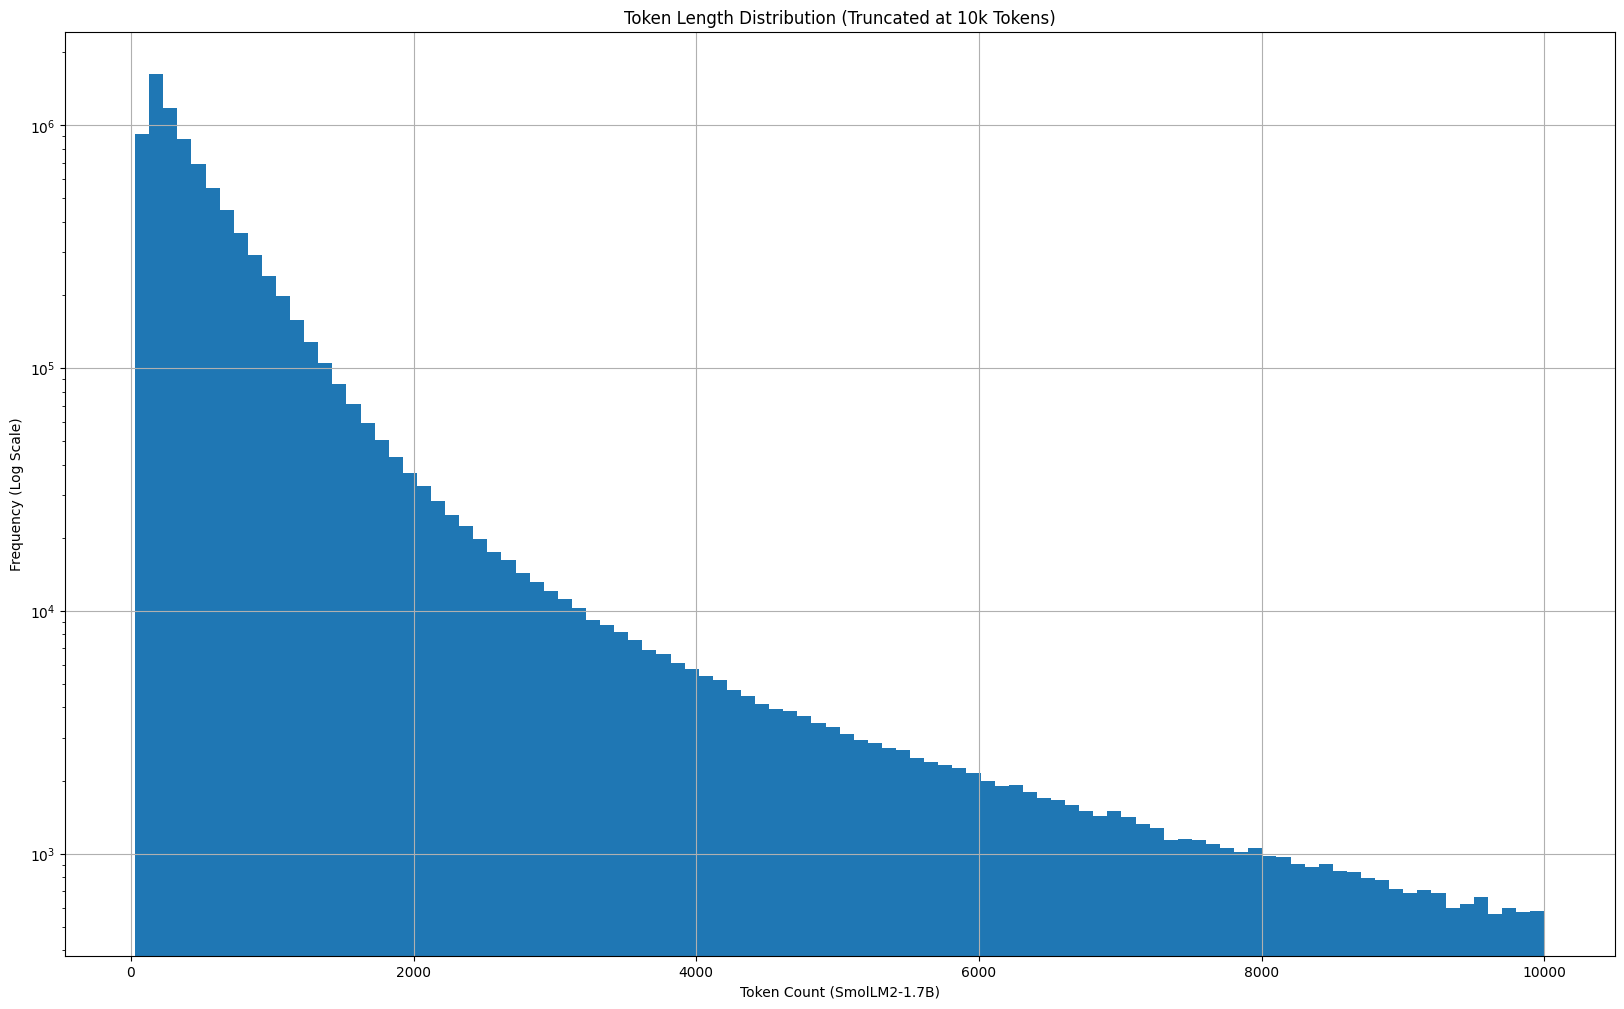

In [16]:
# plot distribution (use log scale for better viz of skew)
plt.figure(figsize=(20, 12))

# zoom into bulk of the data eg. docs < 10K tokens
lengths[lengths < 10000].hist(bins=100, log=True)
plt.title('Token Length Distribution (Truncated at 10k Tokens)')
plt.xlabel('Token Count (SmolLM2-1.7B)')
plt.ylabel('Frequency (Log Scale)')
plt.show()